In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Digital Image Processing — Lab Notebook (Student Version)

This notebook combines the lab materials into a single, ordered workflow.  
Run cells top-to-bottom. Wherever you see **TASK**, complete the short exercise.

**Topics**
1. Bitwise operators & masking  
2. Bit-plane slicing  
3. Histogram processing  
4. Image enhancement  
5. Noise generation

> **Note:** Use your own image files where needed (e.g., `images/sample.jpg`).


## Setup

Run this cell first. It imports the libraries used across the notebook.


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Pure matplotlib display (no cv2 display or color conversion)
def show(img, title=None, cmap=None):
    plt.figure(figsize=(6,4))
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        plt.imshow(img)  # assume already RGB
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


---

# 1) Bitwise Operators & Masking


## Objectives
- Understand AND / OR / XOR / NOT on binary images
- Create simple masks and apply them to regions of interest (ROI)


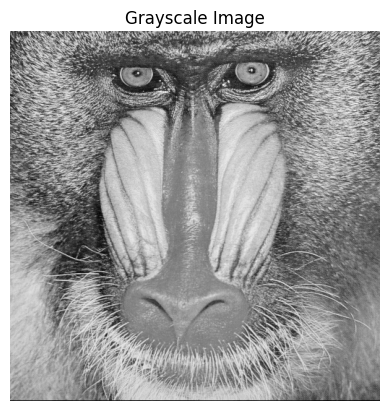

In [4]:
image_data = cv2.imread("/content/drive/MyDrive/DIP/baboon.png", 0)

plt.imshow(image_data, cmap="gray")
plt.title("Grayscale Image")
plt.axis("off")
plt.show()

In [5]:
image_data.shape

(512, 512)

## Bitwise operations


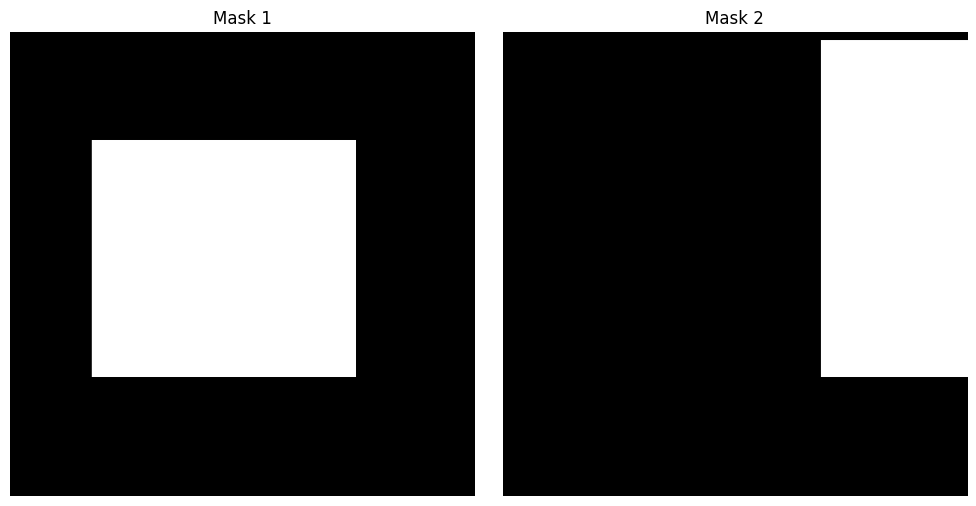

In [7]:
# initialize masks
mask1 = np.zeros(image_data.shape[:2], np.uint8)
mask2 = np.zeros(image_data.shape[:2], np.uint8)

# draw rectangles
cv2.rectangle(mask1, (90, 120), (380, 380), 255, -1)
cv2.rectangle(mask2, (350, 10), (635, 380), 255, -1)

# display using matplotlib
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(mask1, cmap='gray')
plt.title("Mask 1")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask2, cmap='gray')
plt.title("Mask 2")
plt.axis("off")

plt.tight_layout()
plt.show()

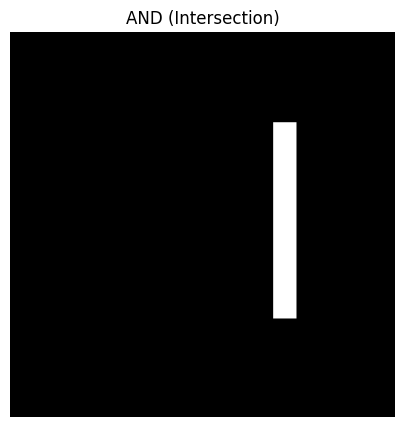

In [8]:
# Shows only where they intersect
And = cv2.bitwise_and(mask1, mask2)

plt.figure(figsize=(5,5))
plt.imshow(And, cmap='gray')
plt.title("AND (Intersection)")
plt.axis("off")
plt.show()

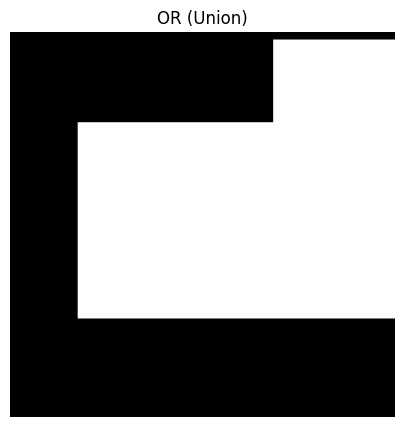

In [9]:
# Shows where either mask1 or mask2 is white
bitwiseOr = cv2.bitwise_or(mask1, mask2)

plt.figure(figsize=(5,5))
plt.imshow(bitwiseOr, cmap='gray')
plt.title("OR (Union)")
plt.axis("off")
plt.show()

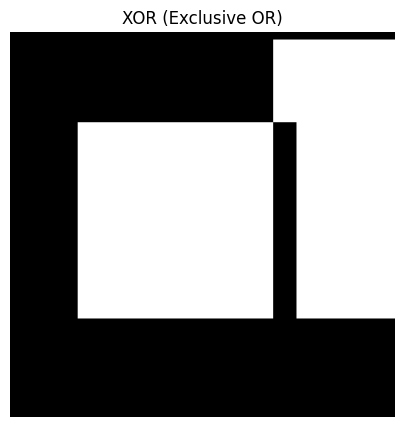

In [10]:
# Shows where either exists by itself (non-overlapping regions)
bitwiseXor = cv2.bitwise_xor(mask1, mask2)

plt.figure(figsize=(5,5))
plt.imshow(bitwiseXor, cmap='gray')
plt.title("XOR (Exclusive OR)")
plt.axis("off")
plt.show()

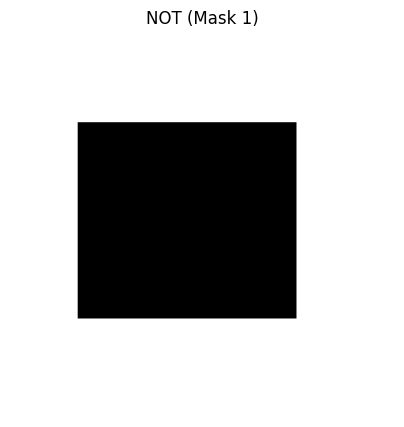

In [11]:
# Shows everything that isn't part of mask1
bitwiseNot_sq = cv2.bitwise_not(mask1)

plt.figure(figsize=(5,5))
plt.imshow(bitwiseNot_sq, cmap='gray')
plt.title("NOT (Mask 1)")
plt.axis("off")
plt.show()

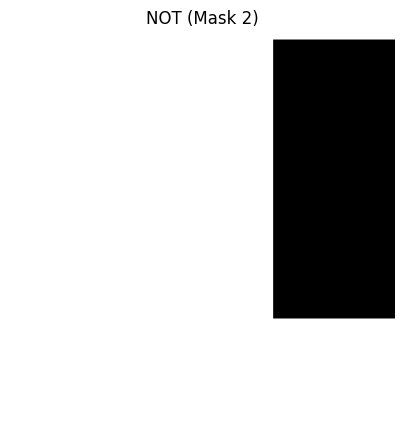

In [12]:
# Invert mask2
bitwiseNot_ell = cv2.bitwise_not(mask2)

plt.figure(figsize=(5,5))
plt.imshow(bitwiseNot_ell, cmap='gray')
plt.title("NOT (Mask 2)")
plt.axis("off")
plt.show()

So far we applied masks together with one another. But we can use the same operators to now apply the masks to the image itself


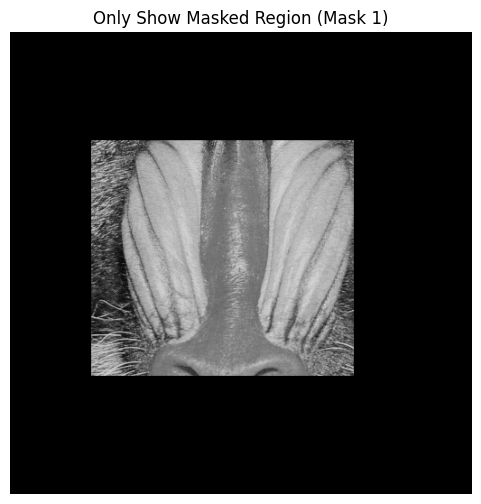

In [13]:
# Apply mask1 to the original image
puppy = cv2.bitwise_and(image_data, image_data, mask=mask1)

# Convert BGR to RGB for correct color display
puppy_rgb = cv2.cvtColor(puppy, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(puppy_rgb)
plt.title("Only Show Masked Region (Mask 1)")
plt.axis("off")
plt.show()

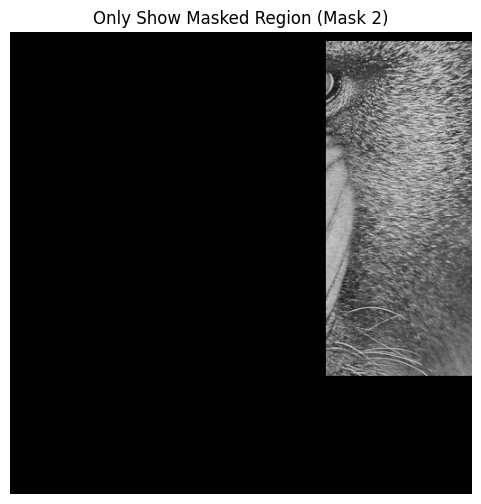

In [14]:
# Apply mask2 to the original image
dog = cv2.bitwise_and(image_data, image_data, mask=mask2)

# Convert BGR to RGB for correct color display
dog_rgb = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(dog_rgb)
plt.title("Only Show Masked Region (Mask 2)")
plt.axis("off")
plt.show()

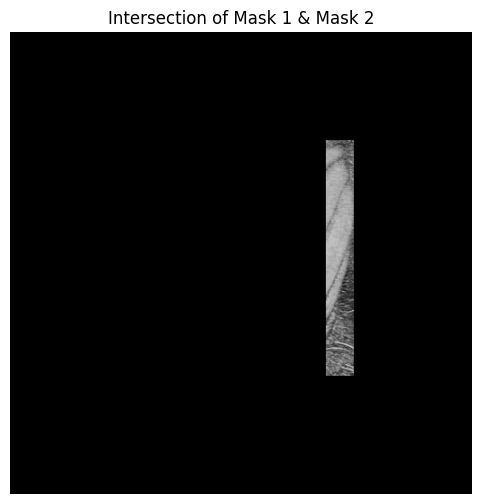

In [15]:
# Apply intersection mask (And) to the original image
dog = cv2.bitwise_and(image_data, image_data, mask=And)

# Convert BGR to RGB
dog_rgb = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(dog_rgb)
plt.title("Intersection of Mask 1 & Mask 2")
plt.axis("off")
plt.show()

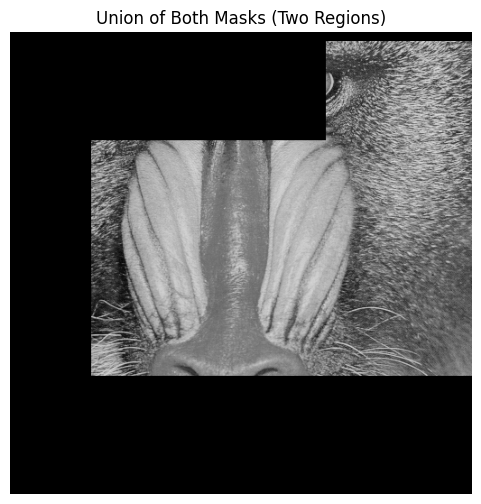

In [16]:
# Apply OR mask to the original image
dog = cv2.bitwise_and(image_data, image_data, mask=bitwiseOr)

# Convert BGR → RGB for proper display
dog_rgb = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(dog_rgb)
plt.title("Union of Both Masks (Two Regions)")
plt.axis("off")
plt.show()

### TASK 1 — Create a circular mask (easy)

1. Load or create a grayscale image (e.g., a synthetic gradient).
2. Create a **circular** binary mask.
3. Use `cv2.bitwise_and` to keep only pixels inside the circle.

Write your solution in the cell below.


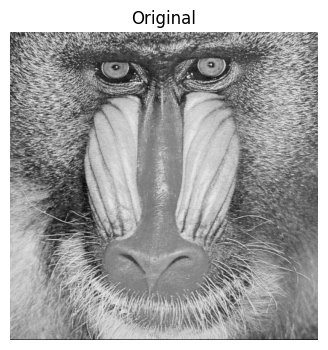

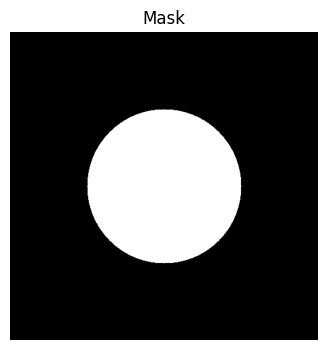

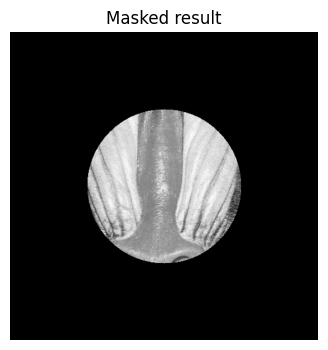

In [19]:
# TODO: Replace this synthetic image with your own if you like
img = cv2.imread("/content/drive/MyDrive/DIP/baboon.png", cv2.IMREAD_GRAYSCALE)

#

h, w = img.shape
mask = np.zeros((h,w), dtype=np.uint8)

# TODO: define center and radius, then draw the circle on mask
cx, cy = w//2, h//2
r = min(h,w)//4
cv2.circle(mask, (cx, cy), r, 255, -1)

# TODO: apply mask
masked = cv2.bitwise_and(img, img, mask=mask)

show(img, "Original", cmap="gray")
show(mask, "Mask", cmap="gray")
show(masked, "Masked result", cmap="gray")


Reflection: The circular mask isolated a specific region of interest. By using bitwise_and, pixels outside the circle became zero (black), effectively focusing the processing on the central area of the image

---

# 2) Bit-Plane Slicing


## Objectives
- Extract and visualize bit-planes (0–7) of an 8-bit grayscale image
- Observe how higher-order planes carry most structural information


# Bit-plane Slicing

**Image** is basically combination of individual pixel (dots) information. When we write that image is of 620 X 480 size, it means that image has 620 pixel in horizontal direction and 480 pixel in vertical direction. So, altogether there is 620 X 480 pixels and each pixels contains some information about image.

**Grayscale** image are basically those image which we say black and white image. Each pixel of grayscale image has a value lies in between **0 – 255** which decides at which position, the image will be black and at which position, it will be white.

If pixel value is **0**, it means that pixel color will be fully black and if pixel value is **255**, then that pixel will be fully white and pixel having intermediate value will be having shades of black and white.

We are given a Grayscale Image. Since pixel value of grayscale image lies between **0 -255**, so its information is contained using **8 bit**.

So, we can divide those image into **8 planes** (8 Binary Image or **8 B&W image**). Binary image are those images whose pixel value can be either 0 or 1.

So, Our task is to extract each bit planes of original image to make 8 binary image

### for example
pixel of grayscale image has value **212**. So, its binary value will be **11010100**. So, its 1st bit is 0, 2nd is 0, 3rd is 1, 4rth is 0, 5th is 1, 6th is 0, 7th is 1, 8th is 1. In this manner, we will take these 8 bit of all pixel and will draw 8 binary image. We have to do this to all the pixels and generate new images.


A gray scale image has pixels with values between 0 and 255 and we need 8 bits to
store these numbers, in this method we extract these 8 bits and each pixel can
represent 8 binary numbers (0,1) and therefore We can have 8 matrices (8 black and
white images) for a gray scale image, which are the elements or planes that make up
the original image.

When we move from low value bit planes (Bit0) to high value planes (Bit7), we get
more information in them.
So we can delete low-value planes (such Bit0) and still have the original image
information.


### TASK 2 — Reconstruct an image from selected bit-planes

1. Extract bit-planes `b7`, `b6`, `b5` (the three most significant planes).
2. Reconstruct an approximation of the original image using only these planes.
3. Compare reconstruction vs original visually.

Implement below.


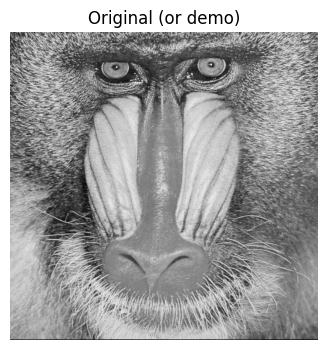

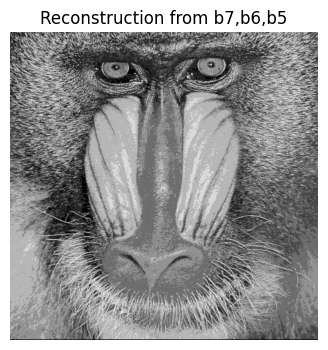

In [21]:
# TODO: load an image (grayscale)
img = cv2.imread("/content/drive/MyDrive/DIP/baboon.png", cv2.IMREAD_GRAYSCALE)

# Demo fallback (remove if using your own image):
# img = (np.random.rand(256,256)*255).astype(np.uint8)

# Extract planes (planes[i] is bit i)
planes = [(img >> i) & 1 for i in range(8)]

# Reconstruct using planes 7,6,5
recon = np.zeros_like(img, dtype=np.uint8)
for i in [7,6,5]:
    recon = recon + (planes[i].astype(np.uint8) << i)

show(img, "Original (or demo)", cmap="gray")
show(recon, "Reconstruction from b7,b6,b5", cmap="gray")


---

# 3) Histogram Processing


## Objectives
- Compute and plot image histograms
- Perform histogram equalization and contrast stretching


# Image Histogram Processing

![histogram of an image](dataset/imgs/histeq.png)

In this section you will see how to calculate and plot the histogram and cumulative histogram of an image using OpenCV in python.

You can find more information in OpenCV documentation and tutorials.
[here](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html)


Install and Import required packages necessary for image processing.

install required packages with python packages manager (PIP)
```cmd
pip install opencv-python
pip install matplotlib
pip install numpy
pip install scikit-image
```


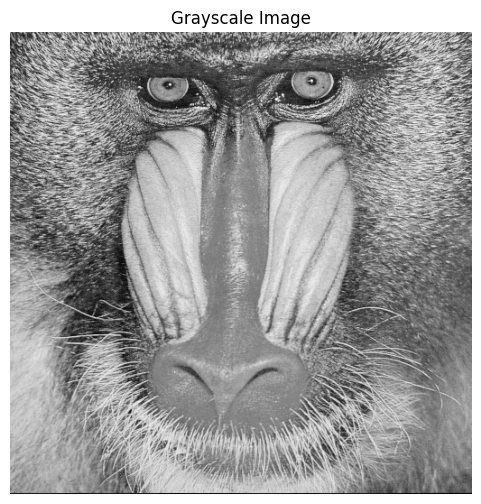

In [23]:
# Read image in grayscale
img = cv2.imread('/content/drive/MyDrive/DIP/baboon.png', 0)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")
plt.show()

## 1-Histogram of an image

**cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])**

**images** : it is the source image of type uint8 or float32. it should be given in square brackets, ie, "[img]".

**channels** : it is also given in square brackets. It is the index of channel for which we calculate histogram. For example, if input is grayscale image, its value is [0]. For color image, you can pass [0], [1] or [2] to calculate histogram of blue, green or red channel respectively.

**mask** : mask image. To find histogram of full image, it is given as "None". But if you want to find histogram of particular region of image, you have to create a mask image for that and give it as mask.

**histSize** : this represents our BIN count. Need to be given in square brackets. For full scale, we pass [256].

**ranges** : this is our RANGE. Normally, it is [0,256].


Text(0, 0.5, 'Frequency')

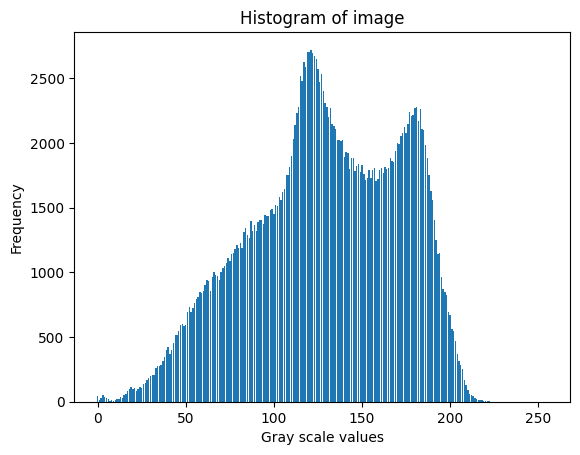

In [24]:
hist = cv2.calcHist(images=[img], channels=[0], mask=None, histSize=[256], ranges=[0, 255])

plt.bar(range(256), hist.ravel())
plt.title('Histogram of image')
plt.xlabel('Gray scale values')
plt.ylabel('Frequency')

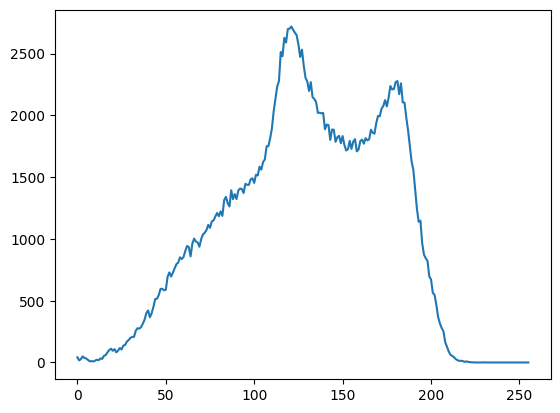

In [25]:
# Another method
hist,bins = np.histogram(img.ravel(),256,[0,256])
plt.plot(hist)

Let's look at another example.


In [33]:
# Let's read two other images
high = cv2.imread('/content/drive/MyDrive/DIP/lena_color_256.tif')
low = cv2.imread('/content/drive/MyDrive/DIP/baboon.png')

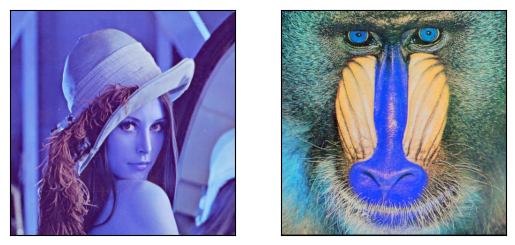

In [43]:
# show images
plt.subplot(121), plt.imshow(high)
plt.grid(False), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(low)
plt.grid(False), plt.xticks([]), plt.yticks([])
plt.show()

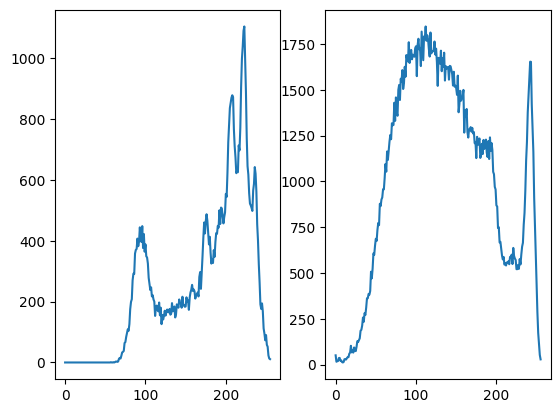

In [35]:
# Calculate histogram of both images for the last channel.
hist_high = cv2.calcHist([high],[2],None,[256],[0,256])
hist_low = cv2.calcHist([low],[2],None,[256],[0,256])

# Plot histograms
plt.subplot(121)
plt.plot(hist_high)

plt.subplot(122)
plt.plot(hist_low)

plt.show()

## 2-Cumulative histogram of an image

**Calculate cumulative distribution function (CDF) of an image**

The cumulative histogram of an image is produced by calculating the cumulative sum of that image's histogram. There is no specific function in OpenCV to obtain the CDF of an image; thus we use the cumsum function in Numpy. You can find more about the function [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html)


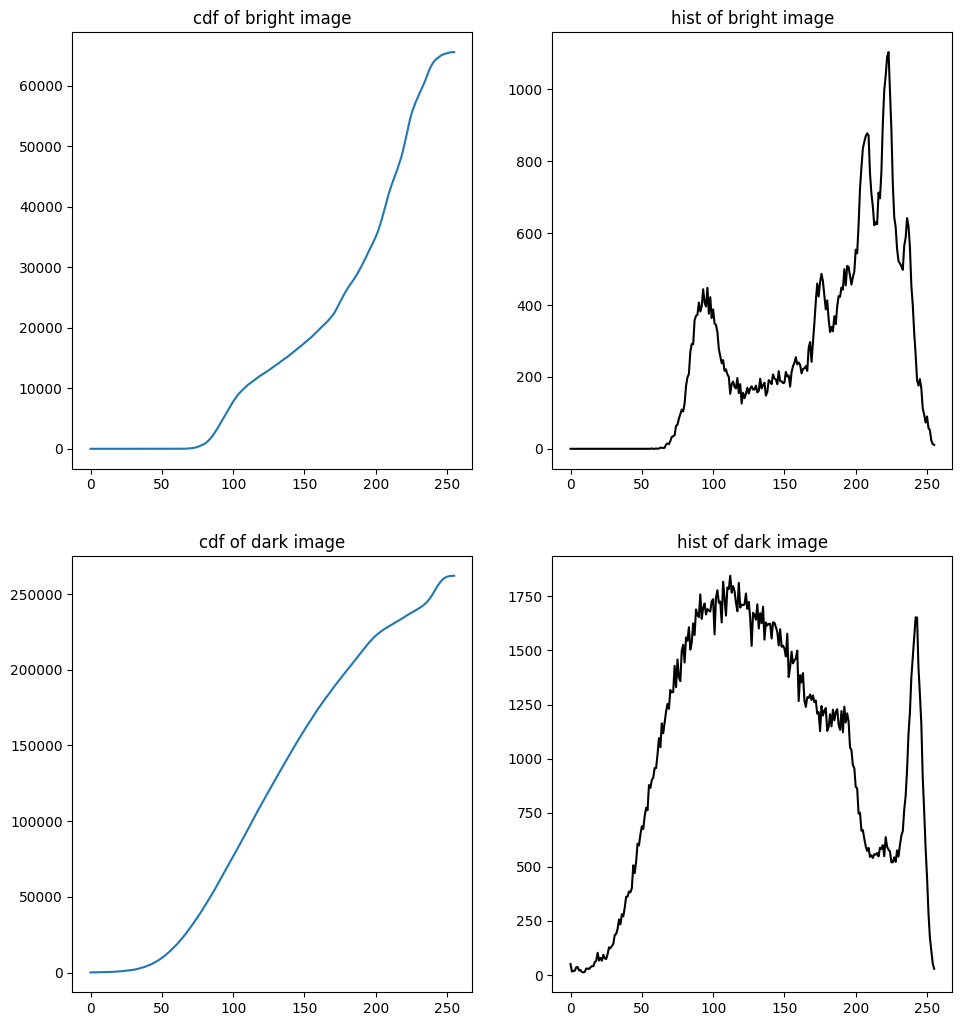

In [36]:
cdf_low = hist_low.cumsum()
cdf_high = hist_high.cumsum()

# plot cumulative histograms
plt.subplot(221), plt.plot(cdf_high), plt. title('cdf of bright image')
plt.subplot(222), plt.plot(hist_high, 'k'), plt. title('hist of bright image')

plt.subplot(223), plt.plot(cdf_low), plt. title('cdf of dark image')
plt.subplot(224), plt.plot(hist_low, 'k'), plt. title('hist of dark image')

plt.subplots_adjust(bottom=1, right=1.5, top=3)
plt.show()

## 3-Histogram manipulation

In order to continue image manipulation, first of all, we change the RGB images to grayscale using `cv2.cvtColor()`.


In [37]:
low_gray = cv2.cvtColor(low, cv2.COLOR_BGR2GRAY)
high_gray = cv2.cvtColor(high, cv2.COLOR_BGR2GRAY)

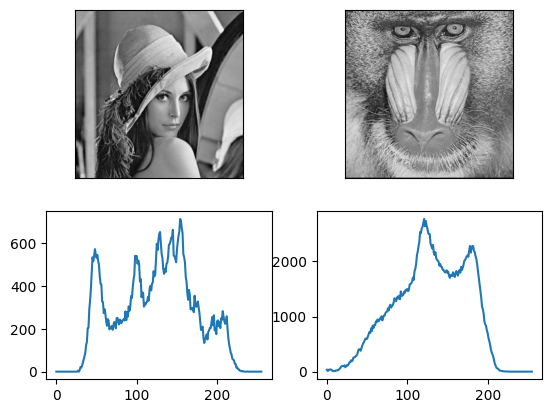

In [38]:
# show images and their histograms
plt.subplot(221), plt.imshow(high_gray, cmap='gray')
plt.grid(False), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.plot(cv2.calcHist([high_gray],[0],None,[256],[0,256]))

plt.subplot(222), plt.imshow(low_gray, cmap='gray')
plt.grid(False), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.plot(cv2.calcHist([low_gray],[0],None,[256],[0,256]))

plt.show()

# Histogram Processing
Histogram of an image can share valuable information with us.

## Thresholding

Thresholding is the simplest histogram processing application.

np.histogram : Another way to calculate the image histogram is with **numpy** library


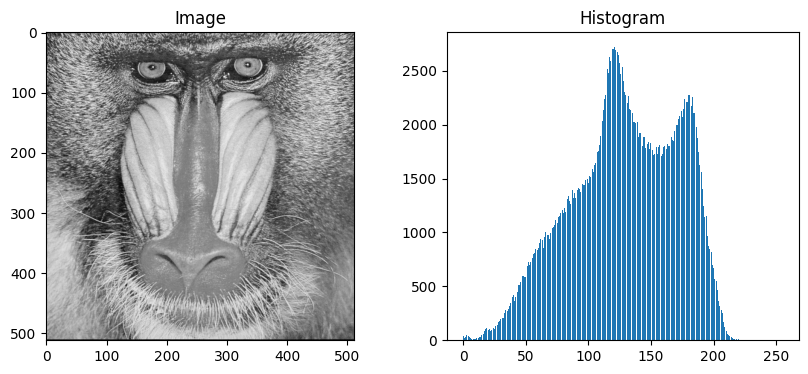

In [44]:
# Проверяем загрузку изображения перед расчетом гистограммы
img = cv2.imread("/content/drive/MyDrive/DIP/baboon.png", 0) # Используем известный рабочий путь для теста

if img is not None:
    img_hist = np.histogram(img.ravel(), bins=256, range=(0, 256))

    plt.figure(figsize=(10, 4))
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title("Image")
    plt.subplot(122), plt.bar(img_hist[1][:-1], img_hist[0])
    plt.title("Histogram")
    plt.show()
else:
    print("Ошибка: Изображение не найдено по указанному пути.")

### thresholded

```python
thresholded = img < t
plt.imshow(thresholded)
```


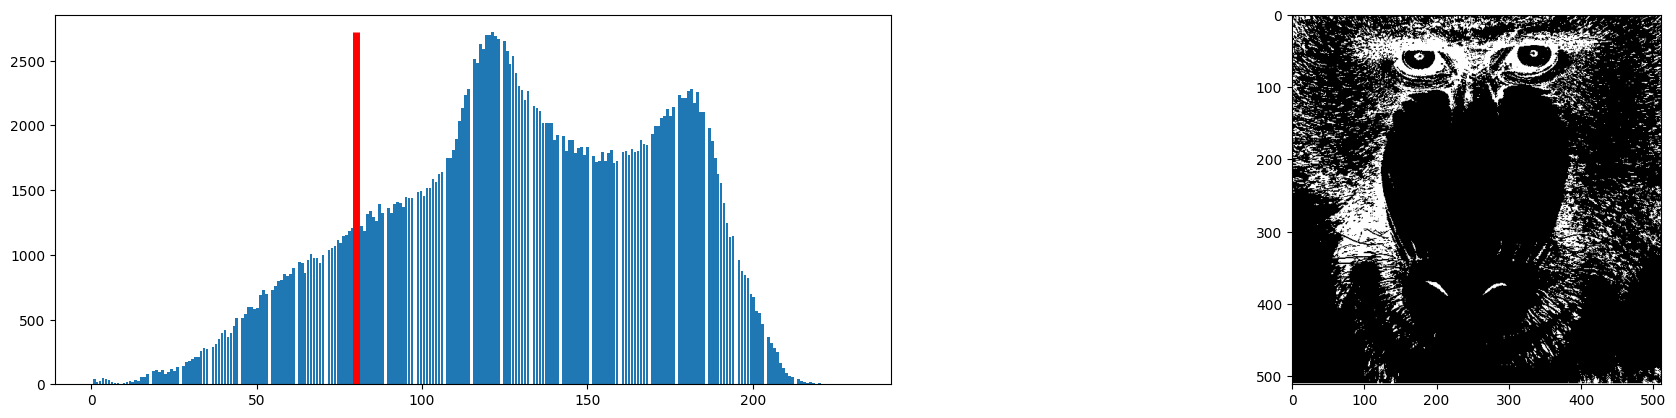

[False  True  True  True False  True  True False False False False False
 False False False False False  True  True False False False False False
 False False  True  True  True  True False False False False False False
 False False False False False False False False False False False False
 False  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True False False False  True  True
 False False False False  True  True  True  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [41]:
t = 80
thresholded = img < t

plt.subplot(121)
plt.bar(img_hist[1][1:], img_hist[0])
plt.vlines(t, 0, np.amax(img_hist[0]), colors='r', linewidth=5)
plt.subplot(122)
plt.imshow(thresholded, cmap="gray")
plt.subplots_adjust(right=3)
plt.show()

print(thresholded[150])

Reflection: Reconstructing the image from only the 3 most significant bits (7, 6, and 5) preserves the overall structure and content. This shows that the lower-order bits mostly contain fine noise and less visual information.

### TASK 3 — Histogram equalization comparison

1. Load a low-contrast grayscale image.
2. Apply:
   - `cv2.equalizeHist`
   - CLAHE (`cv2.createCLAHE`)
3. Plot histograms for original and both outputs.

Use simple matplotlib plots.


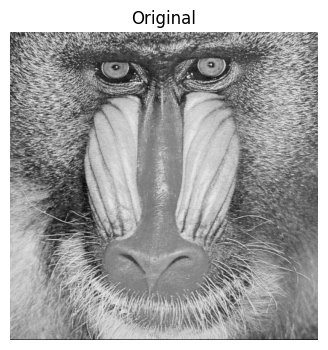

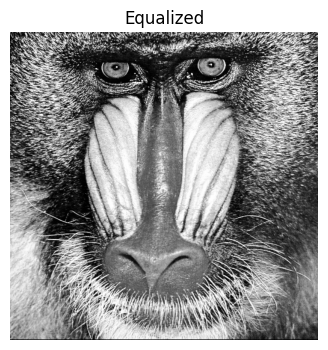

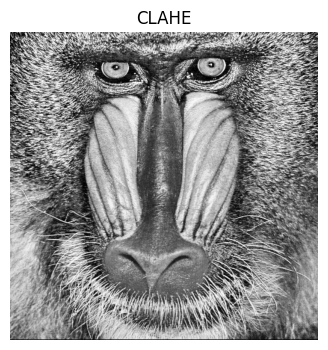

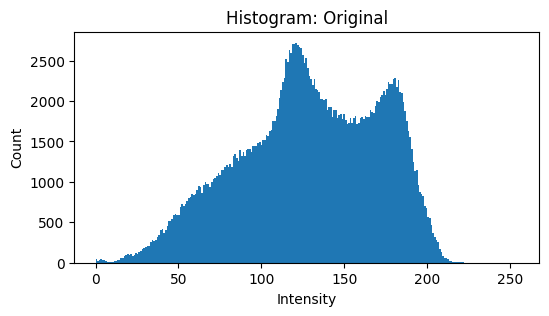

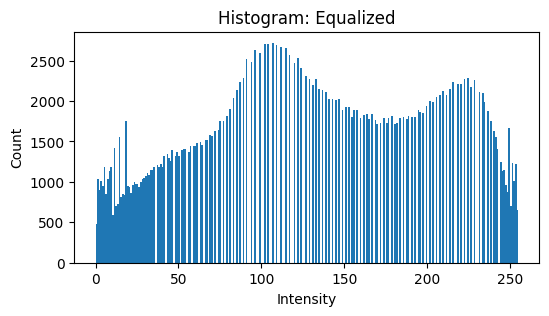

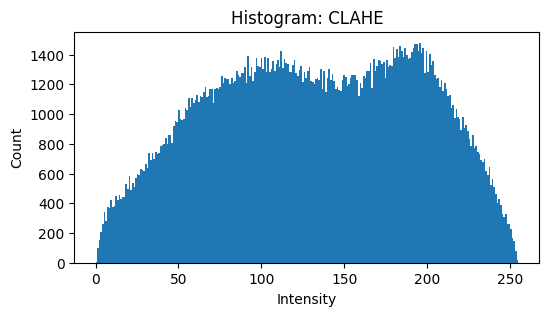

In [46]:
# TODO: load your image
img = cv2.imread("/content/drive/MyDrive/DIP/baboon.png", cv2.IMREAD_GRAYSCALE)

# Demo fallback
# img = np.uint8(np.clip(120 + 20*np.random.randn(256,256), 0, 255))

eq = cv2.equalizeHist(img)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(img)

def plot_hist(a, title):
    plt.figure(figsize=(6,3))
    plt.hist(a.ravel(), bins=256, range=(0,255))
    plt.title(title)
    plt.xlabel("Intensity")
    plt.ylabel("Count")
    plt.show()

show(img, "Original", cmap="gray")
show(eq, "Equalized", cmap="gray")
show(clahe, "CLAHE", cmap="gray")

plot_hist(img, "Histogram: Original")
plot_hist(eq, "Histogram: Equalized")
plot_hist(clahe, "Histogram: CLAHE")


---

# 4) Image Enhancement


## Objectives
- Apply basic enhancement operations (gamma, log, sharpening)
- Compare the effect of parameters on visibility of detail


## Image Enhancement (Contrast Enhancement)

The process to enhance the visual quality of an image by manipulating its histogram (contrast) is called contrast enhancement. This process can be performed by using multiple linear or non-linear functions.

![Contrast Enhancement](dataset/imgs/contrast.png)

One of the methods to normalize and increase the quality and transparency of images in image processing is this method. if we stretch the histogram of the first image, we get a new normalized image. this will make the image clearer and brighter.
The main concept of this method is to reduce the density of tangled pixels and stretch it and make the most gray intensity of the image occur and appear and reduce its darkness because in the original image we have the accumulation of close pixels.
for calculate the new pixel in this method, we have this formula:

**P_out=(P_in-c)((b-a)/(d-C))+a**


#### For Image Enhancement in this section we describe two methods

- Contrast stretching
- Histogram Stretching

![Contrast Enhancement](dataset/imgs/Image-Enhancement.png)


### For Example : Contrast stretching

![Contrast Enhancement](dataset/imgs/contrast-stretching-example.png)

**P_out=(P_in-c)((b-a)/(d-C))+a**

```text
P_out ∶ new pixel (normalized)
a,b∶ the range of numbers we want to normalize => (0, 255) 8-bit
c: the smallest gray scale pixel in the first image => c=10
d: the largest gray scale pixel in the first image => d=249
```


```
P0 = (249-10) * ((255-0)/(249-10))+0 = 255   
P1 = (108-10) * (1.06) = 103.88 ≈104
P2 = (110-10) * (1.06) = 106
P3 = (113-10) * (1.06) = 109.18 ≈ 109
P4 = (10-10) * (1.06) = 0
P5 = (98-10) * (1.06) = 93.28 ≈ 93
P6 = (108-10) * (1.06) = 103.88 = 104
P7 = (114-10) * (1.06) = 110.24 ≈ 110
P8 = (85-10) * (1.06) = 79.5 ≈ 80
P9 = (100-10) * (1.06) = 95.4 ≈ 95
P10 = (96-10) * (1.06) = 91.16 ≈ 91
P11 = (104-10) * (1.06) = 99.64 ≈ 100	     	  
P12 = (85-10) * (1.06) = 79.5 ≈ 80
P13 = (87-10) * (1.06) = 81.62 ≈ 82
P14 = (95-10) * (1.06) = 90.10 ≈ 90
P15 = (98-10) * (1.06) = 93.28 ≈ 93
```

### New Image after contrast stretching
```text
255	104	106	109
0	93	104	110
80	95	91	100
80	82	90	93
```


### Histogram Stretching

![Histogram stretching definition](http://s10.picofile.com/file/8396260626/transformation.PNG)


## Example1: Contrast stretching


P_out=(P_in-c)((b-a)/(d-C))+a


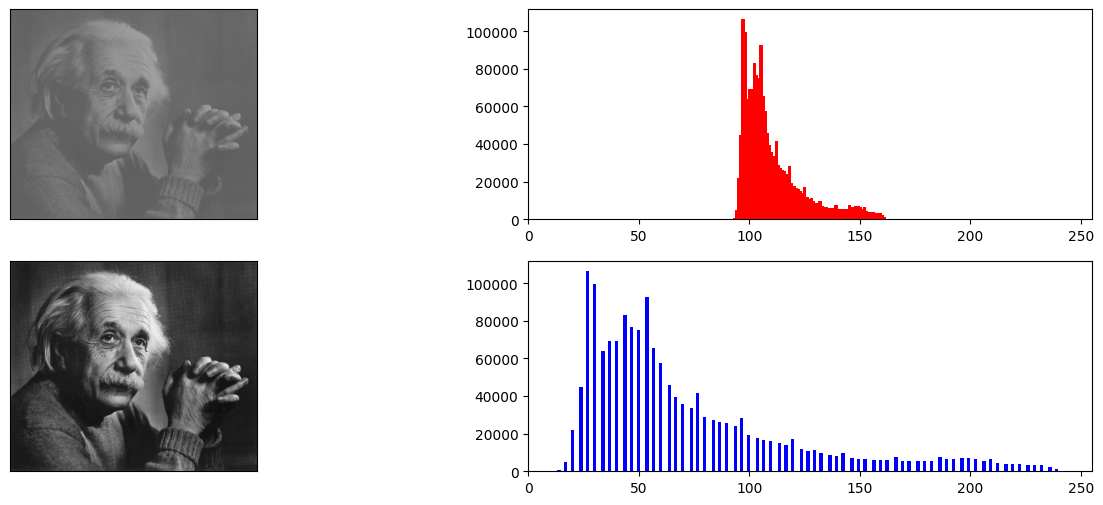

[[[62.92207792 62.92207792 62.92207792]
  [59.61038961 59.61038961 59.61038961]
  [56.2987013  56.2987013  56.2987013 ]
  ...
  [72.85714286 72.85714286 72.85714286]
  [76.16883117 76.16883117 76.16883117]
  [79.48051948 79.48051948 79.48051948]]

 [[59.61038961 59.61038961 59.61038961]
  [59.61038961 59.61038961 59.61038961]
  [56.2987013  56.2987013  56.2987013 ]
  ...
  [76.16883117 76.16883117 76.16883117]
  [79.48051948 79.48051948 79.48051948]
  [82.79220779 82.79220779 82.79220779]]

 [[56.2987013  56.2987013  56.2987013 ]
  [56.2987013  56.2987013  56.2987013 ]
  [52.98701299 52.98701299 52.98701299]
  ...
  [72.85714286 72.85714286 72.85714286]
  [76.16883117 76.16883117 76.16883117]
  [76.16883117 76.16883117 76.16883117]]

 ...

 [[46.36363636 46.36363636 46.36363636]
  [46.36363636 46.36363636 46.36363636]
  [46.36363636 46.36363636 46.36363636]
  ...
  [49.67532468 49.67532468 49.67532468]
  [52.98701299 52.98701299 52.98701299]
  [52.98701299 52.98701299 52.98701299]]

 [

In [47]:
# Compute histogram of the image
image = cv2.imread("/content/drive/MyDrive/IP/dataset/einstein low contrast.tif")
hist_img = np.histogram(image, bins=256)

# Create the stretched image by normalizing it between 0 and L-1.
stretched_img = (255 - 0) / (np.amax(image) - np.amin(image)) * (image - np.amin(image))
hist_strch = np.histogram(stretched_img, bins=256)

# Original image ---------------------------------------------------
plt.figure(figsize=(16, 6))
plt.subplot(221), plt.xticks([]), plt.yticks([])
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

plt.subplot(222), plt.xlim([0, 255])
plt.bar(hist_img[1][1:], hist_img[0], color='red', width=1.5)

# Stretched image ---------------------------------------------------
plt.subplot(223), plt.xticks([]), plt.yticks([])
plt.imshow(stretched_img.astype('uint8'), cmap='gray', vmin=0, vmax=255)

plt.subplot(224), plt.xlim([0, 255])
plt.bar(hist_strch[1][1:], hist_strch[0], color='blue', width=1.5)

plt.show()

print(stretched_img)

## Example2: Contrast stretching


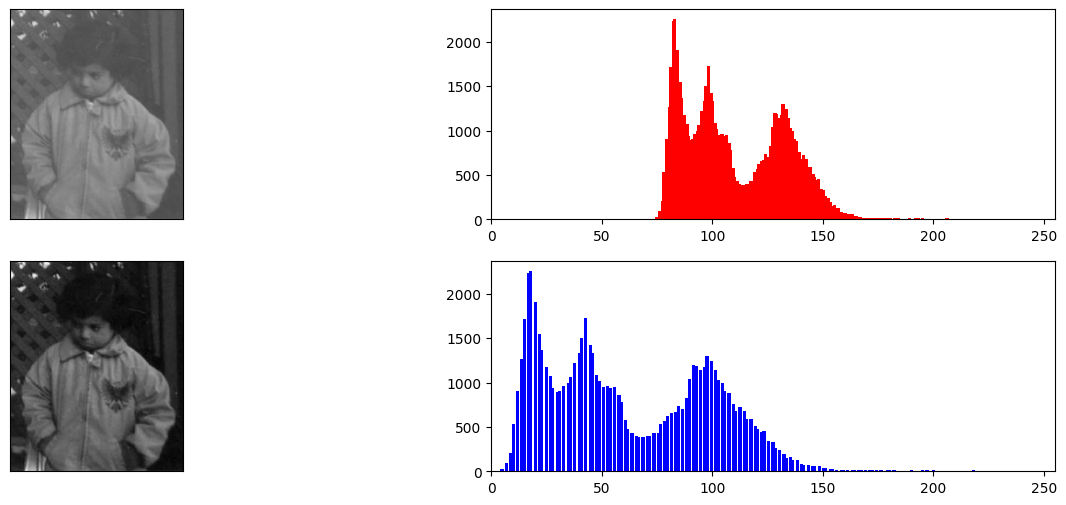

[[58.47133758 61.71974522 61.71974522 ... 21.11464968 21.11464968
  19.49044586]
 [56.84713376 60.0955414  61.71974522 ... 21.11464968 21.11464968
  19.49044586]
 [53.59872611 58.47133758 60.0955414  ... 21.11464968 19.49044586
  19.49044586]
 ...
 [43.85350318 40.60509554 40.60509554 ... 14.61783439 16.24203822
  17.86624204]
 [45.47770701 40.60509554 40.60509554 ... 22.7388535  24.36305732
  27.61146497]
 [45.47770701 40.60509554 40.60509554 ... 34.10828025 35.73248408
  37.3566879 ]]


In [48]:
# Compute histogram of the image
image = cv2.imread("/content/drive/MyDrive/IP/dataset/pout.jpg", 0)
hist_img = np.histogram(image, bins=256)

# Create the stretched image by normalizing it between 0 and L-1.
stretched = 255 / (np.amax(image) - np.amin(image)) * (image - np.amin(image))
hist_strch = np.histogram(stretched, bins=256)

# Original image ---------------------------------------------------
plt.figure(figsize=(16, 6))
plt.subplot(221), plt.xticks([]), plt.yticks([])
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

plt.subplot(222), plt.xlim([0, 255])
plt.bar(hist_img[1][1:], hist_img[0], color='red', width=1.5)

# Stretched image ---------------------------------------------------
plt.subplot(223), plt.xticks([]), plt.yticks([])
plt.imshow(stretched, cmap='gray', vmin=0, vmax=255)

plt.subplot(224), plt.xlim([0, 255])
plt.bar(hist_strch[1][1:], hist_strch[0], color='blue', width=1.5)

plt.show()

print(stretched)

# Histogram Equalization
Histogram equalization is a method to process images in order to adjust the contrast of an image by modifying the intensity distribution of the histogram. The objective of this technique is to give a linear trend to the cumulative probability function associated to the image.

The processing of histogram equalization relies on the use of the cumulative probability function (cdf). The cdf is a cumulative sum of all the probabilities lying in its domain and defined by:

![Histogram Equalization](dataset/imgs/histeq1.png)
![Histogram Equalization](dataset/imgs/histeq.png)


# For Example

In both contrast stretching and histogram equalization, the objective is to spread the gray levels over the entire allowable gray level range. While stretching is a linear process and is reversible, equalization is a nonlinear process and is irreversible. Histogram equalization tries to redistribute about the same number of pixels for each gray level and it is automatic. Consider the 4 × 4 4-bit image shown in Table 2.4 (left). The gray levels are in the range 0–15.

![Histogram Equalization](dataset/imgs/histeq3.png)

Apply the Histogram Equalization on the above image.


![Histogram Equalization](dataset/imgs/histeq4.png)


New Image (after histogram equalization)

```
9	11	3	11
8	3	5	7
15	15	4	15
15	6	9	1
```


In [49]:
mri_img = cv2.imread('/content/drive/MyDrive/IP/dataset/MRI-spine1.tif', 0)
cameraman_img = cv2.imread('/content/drive/MyDrive/IP/dataset/cameraman.tif', 0)
pout_img = cv2.imread('/content/drive/MyDrive/IP/dataset/pout.jpg', 0)

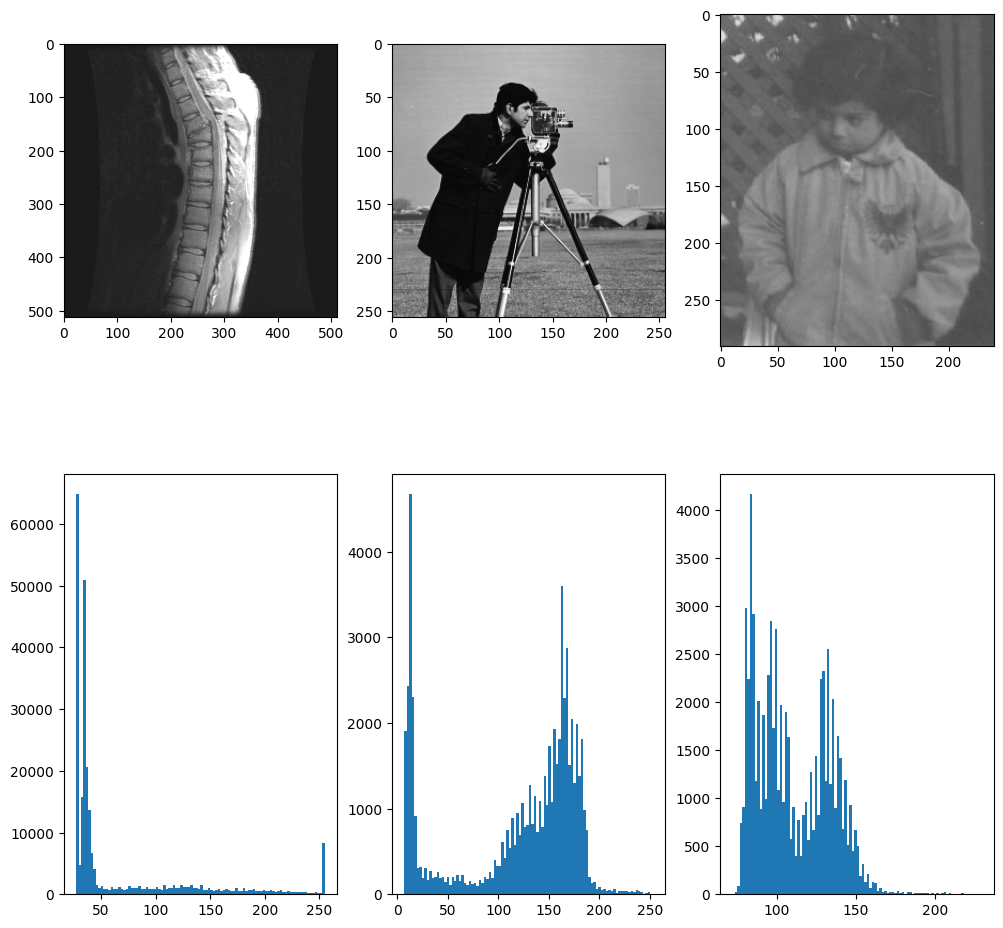

In [50]:
plt.figure(figsize=(12, 12))

plt.subplot(231), plt.imshow(mri_img, cmap='gray', vmin=0, vmax=255)
plt.subplot(234), plt.hist(mri_img.ravel(), bins=100)

plt.subplot(232), plt.imshow(cameraman_img, cmap='gray', vmin=0, vmax=255)
plt.subplot(235), plt.hist(cameraman_img.ravel(), bins=100)

plt.subplot(233), plt.imshow(pout_img, cmap='gray', vmin=0, vmax=255)
plt.subplot(236), plt.hist(pout_img.ravel(), bins=100)

plt.show()

In [51]:
def histogramEqualization(f, bins=100):
    his, be = np.histogram(f, bins=bins)
    his = his.astype(float)/sum(his)
    return np.interp(f, be, np.hstack((np.zeros((1)), np.cumsum(his))))

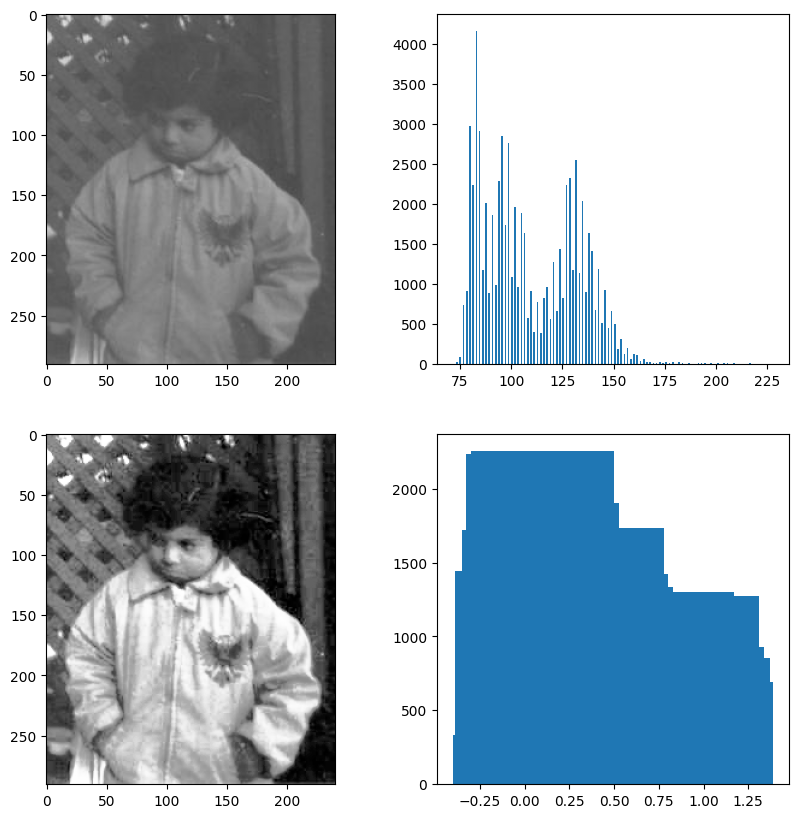

In [52]:
image = pout_img

plt.figure(figsize=(10, 10))

plt.subplot(221), plt.imshow(image, cmap='gray', vmin=0, vmax=255)
histo, range = np.histogram(image, bins=100)
plt.subplot(222), plt.bar(range[:-1], histo)

Eq = histogramEqualization(image)
plt.subplot(223), plt.imshow(Eq, cmap='gray')
histo, range = np.histogram(Eq, bins=100)
plt.subplot(224), plt.bar(range[:-1], histo)

plt.show()

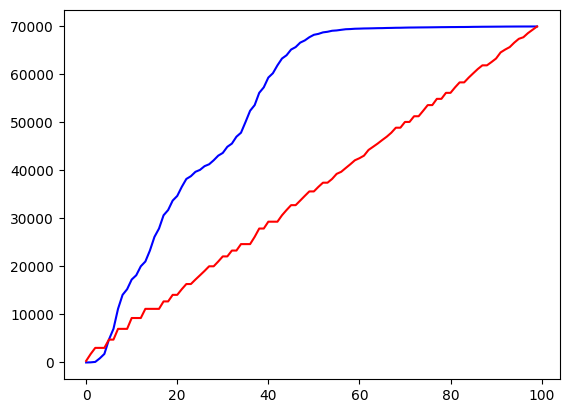

In [53]:
image = pout_img
histo, range = np.histogram(image, bins=100)
cdf_1 = np.cumsum(histo)

Eq = histogramEqualization(image)
histo, range = np.histogram(Eq, bins=100)
cdf_2 = np.cumsum(histo)

plt.figure()
plt.plot(cdf_1, 'b')
plt.plot(cdf_2, 'r')
plt.show()

### skimage.exposure.equalize_hist()

We can use this function to calculate Histogram Equalization


### TASK 4 — Gamma sweep (very easy)

Create a function `apply_gamma(img, gamma)` and test it for **three** values:
- gamma < 1 (brighten)
- gamma = 1 (no change)
- gamma > 1 (darken)

Show the three outputs.


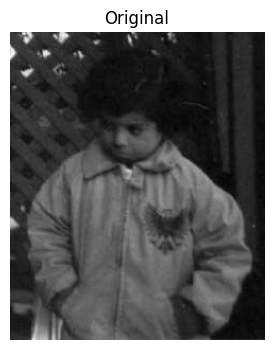

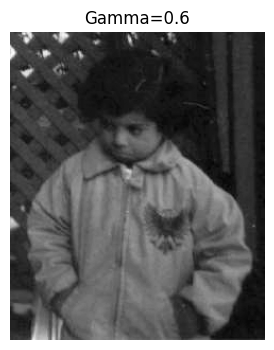

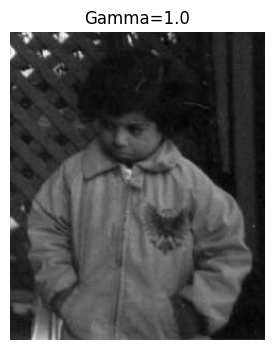

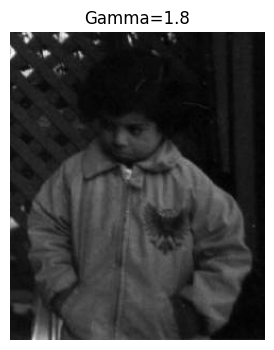

In [55]:
def apply_gamma(img, gamma):
    img = img.astype(np.float32) / 255.0
    out = np.power(img, gamma)
    return np.uint8(np.clip(out*255.0, 0, 255))

# TODO: load grayscale image
img = cv2.imread("/content/drive/MyDrive/IP/dataset/pout.jpg", cv2.IMREAD_GRAYSCALE)

# Demo fallback
# img = np.uint8(np.clip(60 + 80*np.random.rand(256,256), 0, 255))

g1 = apply_gamma(img, 0.6)
g2 = apply_gamma(img, 1.0)
g3 = apply_gamma(img, 1.8)

show(img, "Original", cmap="gray")
show(g1, "Gamma=0.6", cmap="gray")
show(g2, "Gamma=1.0", cmap="gray")
show(g3, "Gamma=1.8", cmap="gray")


---

## Submission checklist
- All TASK cells completed  
- Figures/plots are clear  
- Add 1–2 lines of reflection under each TASK (what changed? why?)


## Reflections on Tasks

### Task 1 — Circular Mask
**Reflection:** The circular mask isolated a specific region of interest. By using `bitwise_and`, pixels outside the circle became zero (black), effectively focusing the processing on the central area of the image.

### Task 2 — Bit-Plane Slicing
**Reflection:** Reconstructing the image from only the 3 most significant bits (7, 6, and 5) preserves the overall structure and content. This shows that the lower-order bits mostly contain fine noise and less visual information.

### Task 3 — Histogram Equalization
**Reflection:** `equalizeHist` improved overall contrast by spreading out intensity values, but CLAHE provided a more balanced result by enhancing local contrast without over-amplifying noise in specific regions.

### Task 4 — Gamma Sweep
**Reflection:** Gamma correction non-linearly shifts the brightness. Gamma < 1 stretched the darker tones (brightening), while Gamma > 1 compressed them (darkening), which is useful for correcting exposure issues.

# Reading and Displaying Images (2 × 5 Grid)

## Objective
In this task, we will:

- Read images from a dataset folder
- Display the first 10 images
- Arrange them in **2 rows and 5 columns**
- Use OpenCV (`cv2`) for reading
- Use Matplotlib for visualization

---

## Step 1 — Import Required Libraries

We use:

- `os` → to access dataset files  
- `cv2` → to read images  
- `matplotlib` → to display images  

---

## Step 2 — Define Dataset Path

Specify the folder containing the images:

```python
dataset_path = "path_to_your_dataset_folder"

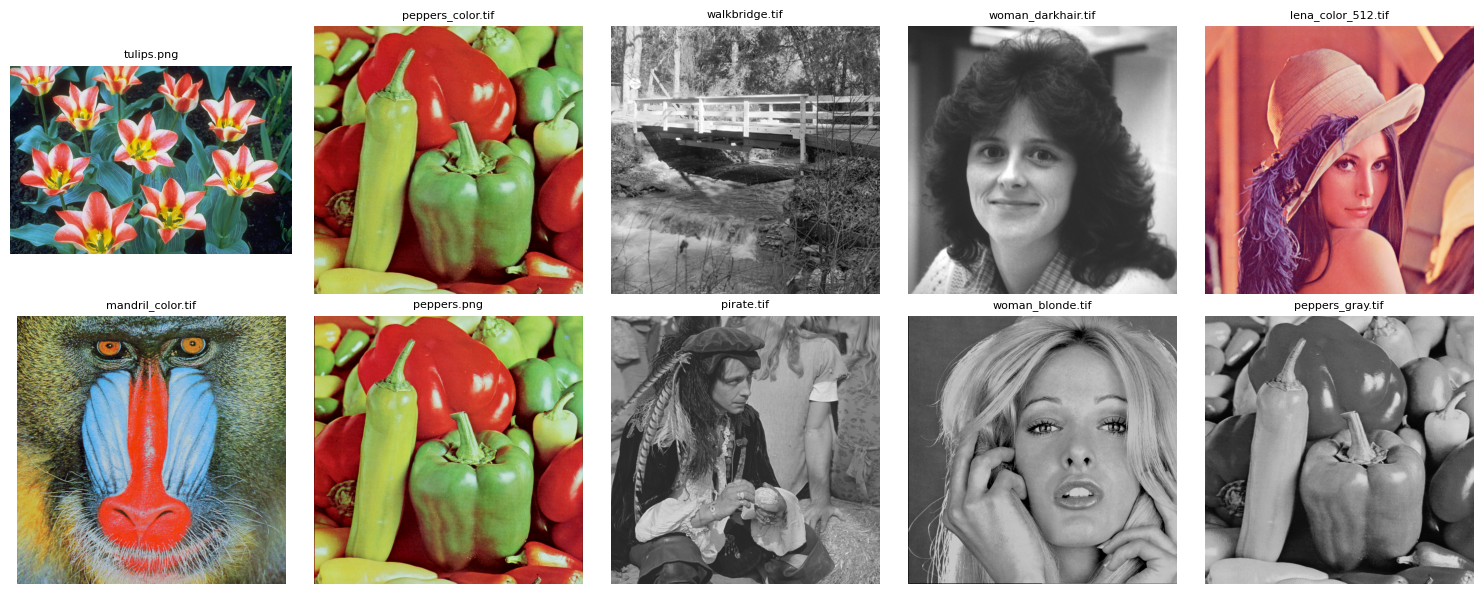

In [60]:
import os
import cv2
import matplotlib.pyplot as plt

# Путь к вашей папке с датасетом
dataset_path = "/content/drive/MyDrive/IP/dataset"

# Получаем первые 10 имен файлов
image_files = os.listdir(dataset_path)[:10]

plt.figure(figsize=(15, 6))

for i, img_name in enumerate(image_files):
    img_path = os.path.join(dataset_path, img_name)

    # Чтение изображения
    img = cv2.imread(img_path)

    if img is not None:
        # Конвертация BGR в RGB для корректного отображения в matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Размещение в сетке 2 строки и 5 колонок
        plt.subplot(2, 5, i + 1)
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(img_name, fontsize=8)
    else:
        print(f"Не удалось загрузить: {img_name}")

plt.tight_layout()
plt.show()

Предупреждение: В папке только 4 изображений.


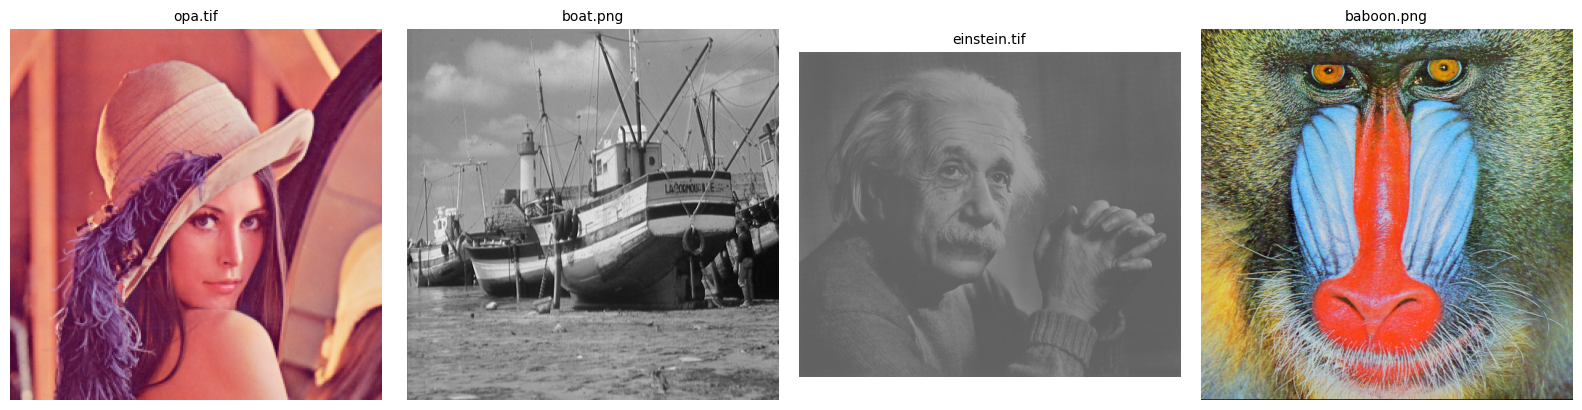

In [61]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Путь к папке с вашими изображениями
dataset_path = '/content/drive/MyDrive/DIP/'

# Получаем список всех файлов в папке
all_images = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]

# Проверяем, достаточно ли изображений
if len(all_images) < 10:
    sample_size = len(all_images)
    print(f"Предупреждение: В папке только {sample_size} изображений.")
else:
    sample_size = 10

# Случайный выбор 10 изображений
random_images = random.sample(all_images, sample_size)

plt.figure(figsize=(20, 8))

for i, img_name in enumerate(random_images):
    img_path = os.path.join(dataset_path, img_name)

    # Загрузка изображения
    img = cv2.imread(img_path)

    if img is not None:
        # Конвертация BGR в RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Создание подзаголовка в сетке 2x5
        plt.subplot(2, 5, i + 1)
        plt.imshow(img_rgb)
        plt.title(img_name, fontsize=10)
        plt.axis('off')
    else:
        print(f"Не удалось загрузить: {img_name}")

plt.tight_layout()
plt.show()

# Task: Randomly Display Images from Dataset (2 × 5 Grid)

## Objective

Write a Python program that:

- Reads images from a dataset folder
- Randomly selects **10 images**
- Displays them in a **2 rows × 5 columns** layout
- Hides axis ticks
- Shows the image filename as the title

---

## Requirements

1. Use the following libraries:
   - `os`
   - `random`
   - `cv2`
   - `matplotlib.pyplot`

2. Randomly select 10 images from the dataset using:
   ```python
   random.sample()

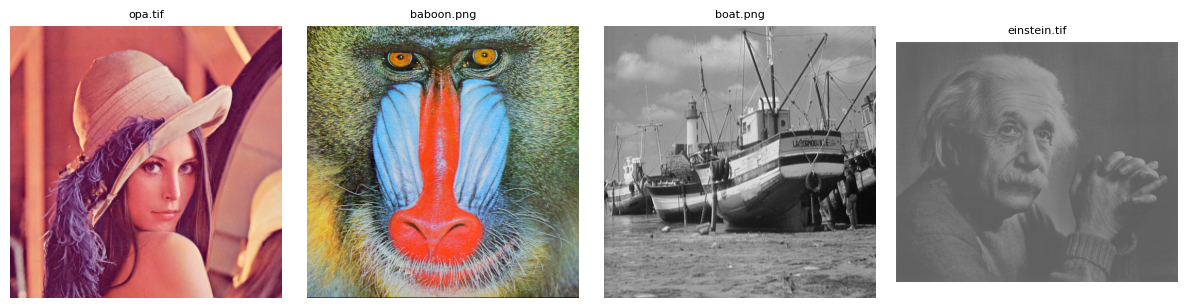

In [63]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Путь к датасету
dataset_path = "/content/drive/MyDrive/DIP/"

# Список файлов
files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]

# Выбираем 10 случайных изображений (или меньше, если в папке недостаточно файлов)
num_to_sample = min(len(files), 10)
sampled_files = random.sample(files, num_to_sample)

plt.figure(figsize=(15, 6))
for i, filename in enumerate(sampled_files):
    img_path = os.path.join(dataset_path, filename)
    img = cv2.imread(img_path)

    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img_rgb)
        plt.title(filename, fontsize=8)
        plt.axis('off')

plt.tight_layout()
plt.show()